In [27]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [28]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [29]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("data",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 5631 files belonging to 4 classes.


In [30]:
class_names=dataset.class_names
class_names

['cloudy', 'desert', 'green_area', 'water']

In [31]:
len(dataset)

176

In [32]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 2, 2, 2, 2, 0, 3, 3, 0, 3, 2, 2, 3, 1, 0, 3, 1, 0, 1, 2, 0, 3,
       3, 0, 0, 3, 2, 3, 2, 1, 2, 1], dtype=int32)>>


2024-04-26 11:19:37.905550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(256, 256, 3), dtype=float32)


2024-04-26 11:19:37.951256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
train_ds=dataset.take(1766)
train_ds
len(train_ds)

176

In [35]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split *ds_size)
    val_size=int(val_split *ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
len(train_ds)

176

In [36]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

140

In [38]:
len(test_ds)

19

In [39]:
len(val_ds)

17

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale=tf.keras.Sequential([
    layers.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/224)
])

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [45]:

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow import keras 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [47]:
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(dataset),activation='softmax')

In [48]:
model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

In [49]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
history = model.fit(train_ds, epochs=EPOCHS, 
                    steps_per_epoch=80,
                    validation_steps=10,
                    validation_data=val_ds)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1589s 20s/step - accuracy: 0.1480 - loss: 3.4901 - val_accuracy: 0.2414 - val_loss: 1.6134
Epoch 2/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 7:04 21s/step - accuracy: 0.2541 - loss: 1.5607

2024-04-26 12:07:44.742313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1428s 18s/step - accuracy: 0.2566 - loss: 1.5575 - val_accuracy: 0.2455 - val_loss: 1.5154
Epoch 3/50


2024-04-26 12:09:56.166124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 5212s 65s/step - accuracy: 0.2624 - loss: 1.4869 - val_accuracy: 0.2320 - val_loss: 1.4748
Epoch 4/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 7:28 22s/step - accuracy: 0.2845 - loss: 1.4327

2024-04-26 13:59:11.363595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 14:01:40.557375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1493s 19s/step - accuracy: 0.2818 - loss: 1.4331 - val_accuracy: 0.2232 - val_loss: 1.4893
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1984s 25s/step - accuracy: 0.3032 - loss: 1.4023 - val_accuracy: 0.2382 - val_loss: 1.4755
Epoch 6/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:37 20s/step - accuracy: 0.2797 - loss: 1.4194

2024-04-26 14:54:36.932079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 14:57:03.072360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1338s 17s/step - accuracy: 0.2784 - loss: 1.4180 - val_accuracy: 0.2455 - val_loss: 1.4858
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1889s 24s/step - accuracy: 0.3113 - loss: 1.3791 - val_accuracy: 0.2382 - val_loss: 1.4362
Epoch 8/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 8:50 27s/step - accuracy: 0.2817 - loss: 1.3979

2024-04-26 15:54:58.882594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 2147s 27s/step - accuracy: 0.2838 - loss: 1.3983 - val_accuracy: 0.2723 - val_loss: 1.4557
Epoch 9/50


2024-04-26 16:04:19.841457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 4039s 51s/step - accuracy: 0.2997 - loss: 1.3821 - val_accuracy: 0.2633 - val_loss: 1.4523
Epoch 10/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 15:35 47s/step - accuracy: 0.2877 - loss: 1.3724

2024-04-26 17:57:59.690041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 3269s 41s/step - accuracy: 0.2903 - loss: 1.3722 - val_accuracy: 0.3080 - val_loss: 1.4093
Epoch 11/50


2024-04-26 18:06:08.026092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 2816s 34s/step - accuracy: 0.2871 - loss: 1.3729 - val_accuracy: 0.2884 - val_loss: 1.4481
Epoch 12/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 9:40 29s/step - accuracy: 0.2878 - loss: 1.3689 

2024-04-26 19:23:05.184069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 19:25:56.804743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1973s 24s/step - accuracy: 0.2909 - loss: 1.3679 - val_accuracy: 0.2232 - val_loss: 1.4197
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4578s 58s/step - accuracy: 0.3122 - loss: 1.3581 - val_accuracy: 0.2288 - val_loss: 1.4542
Epoch 14/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 7:47 23s/step - accuracy: 0.3025 - loss: 1.3568

2024-04-26 21:05:55.034859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1521s 19s/step - accuracy: 0.3026 - loss: 1.3561 - val_accuracy: 0.3304 - val_loss: 1.3861
Epoch 15/50


2024-04-26 21:07:36.210019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1197s 15s/step - accuracy: 0.3233 - loss: 1.3384 - val_accuracy: 0.2688 - val_loss: 1.4194
Epoch 16/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 4:17 13s/step - accuracy: 0.3023 - loss: 1.3464

2024-04-26 21:40:23.446072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 864s 11s/step - accuracy: 0.3041 - loss: 1.3469 - val_accuracy: 0.2735 - val_loss: 1.4330
Epoch 17/50


2024-04-26 21:41:57.130899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1192s 15s/step - accuracy: 0.3225 - loss: 1.3317 - val_accuracy: 0.2875 - val_loss: 1.4110
Epoch 18/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 4:31 14s/step - accuracy: 0.3140 - loss: 1.3454

2024-04-26 22:15:25.873428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 905s 11s/step - accuracy: 0.3129 - loss: 1.3472 - val_accuracy: 0.2646 - val_loss: 1.4670
Epoch 19/50


2024-04-26 22:16:53.783712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1004s 13s/step - accuracy: 0.3301 - loss: 1.3330 - val_accuracy: 0.2438 - val_loss: 1.4231
Epoch 20/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 2:38 8s/step - accuracy: 0.3213 - loss: 1.3323

2024-04-26 22:41:31.481189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 536s 7s/step - accuracy: 0.3214 - loss: 1.3340 - val_accuracy: 0.2735 - val_loss: 1.4312
Epoch 21/50


2024-04-26 22:42:33.954315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 407s 5s/step - accuracy: 0.3143 - loss: 1.3208 - val_accuracy: 0.2969 - val_loss: 1.4233
Epoch 22/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - accuracy: 0.3321 - loss: 1.3449

2024-04-26 22:53:54.086597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.3299 - loss: 1.3448 - val_accuracy: 0.2466 - val_loss: 1.4307
Epoch 23/50


2024-04-26 22:54:24.108838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - accuracy: 0.3159 - loss: 1.3267 - val_accuracy: 0.2875 - val_loss: 1.4130
Epoch 24/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 5:46 17s/step - accuracy: 0.3348 - loss: 1.3387

2024-04-26 23:18:01.379722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1271s 16s/step - accuracy: 0.3322 - loss: 1.3386 - val_accuracy: 0.2377 - val_loss: 1.4600
Epoch 25/50


2024-04-26 23:22:04.431622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 2088s 26s/step - accuracy: 0.3583 - loss: 1.3163 - val_accuracy: 0.3354 - val_loss: 1.4262
Epoch 26/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 8:18 25s/step - accuracy: 0.3141 - loss: 1.3472

2024-04-27 00:21:26.042773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1636s 21s/step - accuracy: 0.3162 - loss: 1.3446 - val_accuracy: 0.2545 - val_loss: 1.4325
Epoch 27/50


2024-04-27 00:24:08.369578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1457s 18s/step - accuracy: 0.3236 - loss: 1.3156 - val_accuracy: 0.2844 - val_loss: 1.4607
Epoch 28/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:05 18s/step - accuracy: 0.3130 - loss: 1.3378

2024-04-27 01:06:29.047073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1256s 16s/step - accuracy: 0.3142 - loss: 1.3356 - val_accuracy: 0.2601 - val_loss: 1.4414
Epoch 29/50


2024-04-27 01:09:21.469123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1508s 19s/step - accuracy: 0.3355 - loss: 1.3080 - val_accuracy: 0.2781 - val_loss: 1.4364
Epoch 30/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:44 20s/step - accuracy: 0.3440 - loss: 1.3062

2024-04-27 01:54:26.569697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1313s 17s/step - accuracy: 0.3421 - loss: 1.3095 - val_accuracy: 0.3184 - val_loss: 1.4210
Epoch 31/50


2024-04-27 01:56:22.718838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1561s 20s/step - accuracy: 0.3397 - loss: 1.3125 - val_accuracy: 0.2906 - val_loss: 1.4013
Epoch 32/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:02 18s/step - accuracy: 0.3494 - loss: 1.3159

2024-04-27 02:40:19.425720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1202s 15s/step - accuracy: 0.3488 - loss: 1.3162 - val_accuracy: 0.2646 - val_loss: 1.4725
Epoch 33/50


2024-04-27 02:42:25.097781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1673s 21s/step - accuracy: 0.3565 - loss: 1.3067 - val_accuracy: 0.2750 - val_loss: 1.4355
Epoch 34/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:26 19s/step - accuracy: 0.3490 - loss: 1.3239

2024-04-27 03:29:22.667080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1321s 17s/step - accuracy: 0.3523 - loss: 1.3190 - val_accuracy: 0.2422 - val_loss: 1.4538
Epoch 35/50


2024-04-27 03:32:19.174865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1619s 20s/step - accuracy: 0.3547 - loss: 1.2856 - val_accuracy: 0.2853 - val_loss: 1.4134
Epoch 36/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:06 18s/step - accuracy: 0.3364 - loss: 1.3088

2024-04-27 04:17:25.260171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1212s 15s/step - accuracy: 0.3371 - loss: 1.3102 - val_accuracy: 0.2277 - val_loss: 1.4860
Epoch 37/50


2024-04-27 04:19:30.855019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1610s 20s/step - accuracy: 0.3450 - loss: 1.2939 - val_accuracy: 0.2476 - val_loss: 1.4453
Epoch 38/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 7:05 21s/step - accuracy: 0.3461 - loss: 1.3034

2024-04-27 05:07:21.466685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1381s 17s/step - accuracy: 0.3469 - loss: 1.3040 - val_accuracy: 0.3393 - val_loss: 1.4667
Epoch 39/50


2024-04-27 05:09:22.272563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1807s 23s/step - accuracy: 0.3437 - loss: 1.2939 - val_accuracy: 0.2759 - val_loss: 1.4371
Epoch 40/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 6:48 20s/step - accuracy: 0.3366 - loss: 1.3048

2024-04-27 06:00:23.843843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1382s 17s/step - accuracy: 0.3413 - loss: 1.3037 - val_accuracy: 0.2634 - val_loss: 1.4416
Epoch 41/50


2024-04-27 06:02:30.833971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 2153s 27s/step - accuracy: 0.3712 - loss: 1.2928 - val_accuracy: 0.2937 - val_loss: 1.4372
Epoch 42/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 27:41 83s/step - accuracy: 0.3601 - loss: 1.3018

2024-04-27 08:00:11.338044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 4952s 63s/step - accuracy: 0.3590 - loss: 1.3006 - val_accuracy: 0.2825 - val_loss: 1.4472
Epoch 43/50


2024-04-27 08:00:55.381131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.3540 - loss: 1.2892 - val_accuracy: 0.2853 - val_loss: 1.4796
Epoch 44/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.3450 - loss: 1.2949

2024-04-27 08:11:54.845042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.3451 - loss: 1.2959 - val_accuracy: 0.3080 - val_loss: 1.4242
Epoch 45/50


2024-04-27 08:12:41.490887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - accuracy: 0.3939 - loss: 1.2737 - val_accuracy: 0.2750 - val_loss: 1.4496
Epoch 46/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.3641 - loss: 1.2993

2024-04-27 08:23:35.364001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - accuracy: 0.3610 - loss: 1.3008 - val_accuracy: 0.2780 - val_loss: 1.4792
Epoch 47/50


2024-04-27 08:24:04.242005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.3787 - loss: 1.2810 - val_accuracy: 0.3125 - val_loss: 1.4553
Epoch 48/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.3644 - loss: 1.2873

2024-04-27 08:34:31.505565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.3664 - loss: 1.2883 - val_accuracy: 0.2063 - val_loss: 1.4564
Epoch 49/50


2024-04-27 08:35:02.507472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 386s 5s/step - accuracy: 0.3669 - loss: 1.2914 - val_accuracy: 0.2821 - val_loss: 1.4849
Epoch 50/50
60/80 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.3610 - loss: 1.2944

2024-04-27 08:45:45.234211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


80/80 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.3613 - loss: 1.2920 - val_accuracy: 0.2411 - val_loss: 1.4229


2024-04-27 08:46:14.817020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [61]:
score= model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.2695 - loss: 1.4165


In [62]:
score

[1.4254753589630127, 0.2763157784938812]

In [63]:
acc=history.history['accuracy']
val_acc =history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [64]:
for image_batch,labels_batch in test_ds.take(1):
    
    print(image_batch[0].numpy())

[[[29.       61.       74.      ]
  [29.       61.       74.      ]
  [28.875    60.875    73.875   ]
  ...
  [29.       58.       74.      ]
  [29.       58.       74.      ]
  [29.       58.       74.      ]]

 [[29.       61.       74.      ]
  [29.       61.       74.      ]
  [28.875    60.875    73.875   ]
  ...
  [29.       58.       74.      ]
  [29.       58.       74.      ]
  [29.       58.       74.      ]]

 [[28.875    60.875    73.875   ]
  [28.875    60.875    73.875   ]
  [28.765625 60.765625 73.765625]
  ...
  [29.109375 58.109375 74.109375]
  [29.125    58.125    74.125   ]
  [29.125    58.125    74.125   ]]

 ...

 [[28.125    60.125    73.125   ]
  [28.125    60.125    73.125   ]
  [28.109375 60.109375 73.109375]
  ...
  [29.234375 58.234375 72.234375]
  [29.125    58.125    72.125   ]
  [29.125    58.125    72.125   ]]

 [[28.       60.       73.      ]
  [28.       60.       73.      ]
  [28.       60.       73.      ]
  ...
  [29.125    58.125    72.125   ]
  [2

2024-04-27 08:58:09.686924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-27 08:58:18.075057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


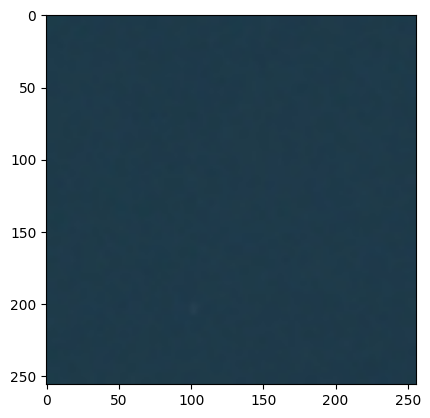

In [67]:
for image_batch,labels_batch in test_ds.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: water
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[3.10266107e-01 2.01511011e-01 2.17487708e-01 2.70487189e-01
 2.68812279e-08 3.43805624e-08 2.11823320e-07 4.05618508e-08
 2.86192147e-07 1.59728710e-08 1.35332201e-07 1.54032360e-08
 2.29009416e-07 1.54787813e-06 1.94270115e-07 1.16607873e-06
 6.99981229e-09 1.01553624e-07 4.09431884e-08 3.34748620e-07
 6.71291502e-07 1.35062095e-07 5.39672085e-09 2.39064121e-07
 3.07269161e-08 1.56652891e-06 2.21253540e-08 1.45042378e-08
 8.93245016e-08 6.99102287e-08 3.73776317e-08 8.51405275e-06
 7.20766025e-08 4.62967478e-07 5.14121301e-10 1.72802345e-06
 3.88002218e-06 1.29368550e-06 2.23394103e-08 4.65837843e-07
 5.46085452e-08 1.81278708e-07 4.54330348e-07 8.52740314e-08
 1.50349331e-06 3.12799102e-07 5.88478940e-07 1.11411623e-07
 3.49416496e-07 2.98790113e-08 2.65568042e-06 1.05561909e-07
 3.42465427e-07 1.46271668e-05 1.05911816e-07 1.93826523e-07
 1.44050841e-06 1.68225242e-07 1.55262910e-07 5.34798481e-08
 2.511

2024-04-27 08:58:42.537923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


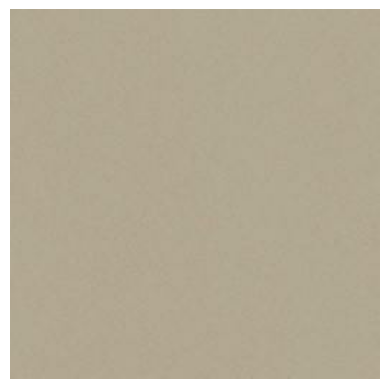

In [70]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2024-04-27 08:58:50.096599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


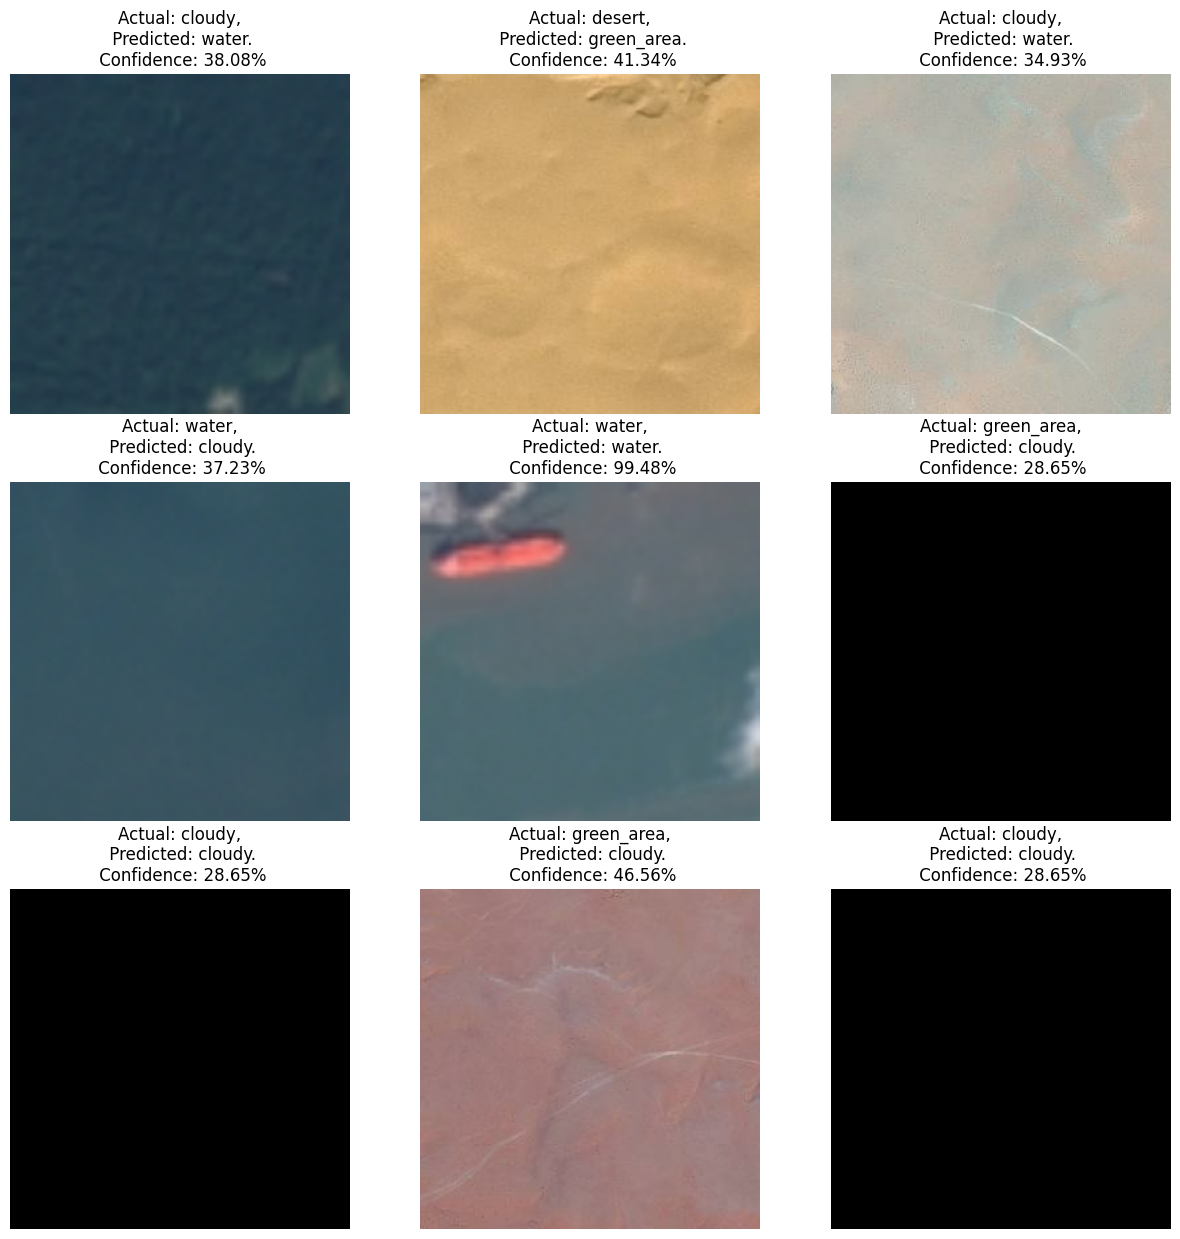

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [76]:
model_version = 1
model_dir = "./model1"
for filename in os.listdir(model_dir):
    try:
        version = int(filename)
        model_version = max(model_version, version)
    except ValueError:
        pass
model_version += 1

# Save the trained model (choose either .h5 or .keras extension)
model.save(f"{model_dir}/{model_version}.h5")  # Use .h5 for HDF5 format
# or
# model.save(f"{model_dir}/{model_version}.keras")  # Use .keras for native Keras format

print(f"Model saved to: {model_dir}/{model_version}.h5")  # Adjust based on saved extension

Model saved to: ./model1/2.h5
